# QNN + QRL + QKD — **Qiskit 2.x** (Corrected Implementation)

This notebook implements **six quantum key distribution / learning algorithms** as described in:

> *"QNN-QRL: Quantum Neural Network Integrated with Quantum Reinforcement Learning for Quantum Key Distribution"*  
> Behera, Al-Kuwari, and Farouk (arXiv:2501.18188v2)

## Corrections from Original Implementation:

1. **Added explicit Q-value tracking** to match the RL formalism in Algorithms 1-2
2. **Added convergence condition** (`|n₃ - n₁| < ε`) as specified in the paper
3. **Clarified PQC structure** with notes about the paper's generic θ⃗ notation
4. **Improved B92 sifting logic** with explanatory comments
5. **Added reward computation** matching Equation (20): `Reward = max(P₀, P₁)`

### Algorithms Implemented:
1. **QRL-V.1** (deterministic angle refinement with Q-values)  
2. **QRL-V.2** (stochastic angle refinement with Q-values)  
3. **QNN-BB84** (BB84 with trainable PQC head)  
4. **QNN-B92** (B92 with trainable PQC head)  
5. **QNN-QRL-V.1** (QRL-V.1 + PQC head)  
6. **QNN-QRL-V.2** (QRL-V.2 + PQC head)

## 0) Installation (Qiskit 2.x)

```bash
pip install "qiskit>=2" "qiskit-aer>=0.16" numpy matplotlib
# Optional (for training PQC parameters with COBYLA):
pip install qiskit-algorithms
```

In [1]:
# !pip install "qiskit>=2" "qiskit-aer>=0.16" numpy matplotlib
# # Optional (for training PQC parameters with COBYLA):
# !pip install qiskit-algorithms

## 1) Imports & Global Configuration

In [2]:
# ============================================================================
# IMPORTS
# ============================================================================
import math
import random
import numpy as np
from typing import Tuple, List, Dict, Optional

# Qiskit 2.x imports
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    pauli_error,
    amplitude_damping_error,
    phase_damping_error,
)

# Optional optimizer for training
try:
    from qiskit_algorithms.optimizers import COBYLA
except ImportError:
    COBYLA = None
    print("Warning: qiskit-algorithms not installed. Training disabled.")

# ============================================================================
# GLOBAL CONFIGURATION (matching paper's experimental setup)
# ============================================================================
NUM_SHOTS = 1024          # Paper: "1024 numbers of shots"
RNG = random.Random(42)   # Fixed seed for reproducibility
NOISE_MODEL: Optional[NoiseModel] = None

# Convergence threshold for QRL algorithms (paper mentions convergence condition)
CONVERGENCE_EPSILON = 0.01

## 2) Helper Functions

In [3]:
def run_counts(circ: QuantumCircuit, shots: int = NUM_SHOTS,
               noise_model: Optional[NoiseModel] = None) -> Dict[str, int]:
    """
    Execute circuit on AerSimulator and return measurement counts.

    Returns:
        dict: e.g., {'0': 512, '1': 512}
    """
    backend = AerSimulator()
    tqc = transpile(circ, backend)
    nm = noise_model if noise_model is not None else NOISE_MODEL

    if nm is not None:
        job = backend.run(tqc, shots=shots, noise_model=nm)
    else:
        job = backend.run(tqc, shots=shots)

    return job.result().get_counts()


def run_and_sample_bit(circ: QuantumCircuit, shots: int = NUM_SHOTS,
                       noise_model: Optional[NoiseModel] = None) -> int:
    """
    Execute circuit and return majority-vote bit (0 or 1).
    """
    counts = run_counts(circ, shots=shots, noise_model=noise_model)
    return int(max(counts, key=counts.get))


def get_probabilities(counts: Dict[str, int], shots: int = NUM_SHOTS) -> Tuple[float, float]:
    """
    Convert counts to probabilities P0 and P1.

    Paper Equation (24):
        P0 = (1 + cos(Δθ))/2
        P1 = (1 - cos(Δθ))/2

    Returns:
        Tuple[float, float]: (P0, P1)
    """
    p0 = counts.get('0', 0) / shots
    p1 = counts.get('1', 0) / shots
    return p0, p1

## 3) Evaluation Metrics

As specified in the paper (Section III):
- **Evaluation metrics** = max{accuracy, precision, recall, F1 score} (Eq. 18)
- **Error rate** = min{QBER} (Eq. 19)
- **QBER** = Number of mismatched bits / Total number of checked bits (Eq. 1)

In [4]:
def compute_classification_metrics(true_bits: List[int],
                                   pred_bits: List[int]) -> Dict[str, float]:
    """
    Compute binary classification metrics.

    Returns:
        dict with 'accuracy', 'precision', 'recall', 'f1'
    """
    y_true = np.array(true_bits)
    y_pred = np.array(pred_bits)

    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))

    n = len(y_true)
    accuracy = (TP + TN) / n if n > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}


def compute_qber(alice_key: List[int], bob_key: List[int]) -> float:
    """
    Compute Quantum Bit Error Rate (QBER) as per Equation (1):

        QBER = Number of mismatched bits / Total number of checked bits
    """
    if len(alice_key) == 0:
        return 0.0
    mismatches = sum(1 for a, b in zip(alice_key, bob_key) if a != b)
    return mismatches / len(alice_key)

## 4) Core Circuit Building

The QRL circuit follows the paper's description (Section III-A, Figure 2):

```
|k⟩ → H → P(θ₁) → P(-θ₂) → H → Measure
```

**Note**: The paper uses P(θ) (phase gate). In Qiskit, we use RZ(θ) which differs by a global phase:
- P(θ) = [[1, 0], [0, e^(iθ)]]
- RZ(θ) = [[e^(-iθ/2), 0], [0, e^(iθ/2)]]

For measurement outcomes, these are equivalent.

In [5]:
def build_alice_bob_circuit(bit_k: int, theta1: float, theta2: float) -> QuantumCircuit:
    """
    Build the QRL-style encode/decode circuit.

    Paper Equations (21-23):
        H|0⟩ = (1/√2)(|0⟩ + |1⟩)
        After P(θ₁) and P(-θ₂): (1/√2)(|0⟩ + e^(iΔθ)|1⟩)
        After final H: ((1+e^(iΔθ))/2)|0⟩ + ((1-e^(iΔθ))/2)|1⟩

    Args:
        bit_k: Alice's bit (0 or 1)
        theta1: Alice's encoding angle
        theta2: Bob's decoding angle

    Returns:
        QuantumCircuit ready for execution
    """
    qc = QuantumCircuit(1, 1)

    # Prepare |k⟩
    if bit_k == 1:
        qc.x(0)

    # Alice's encoding: H → P(θ₁)
    qc.h(0)
    qc.p(theta1, 0)  # Using P gate to match paper exactly

    # Bob's decoding: P(-θ₂) → H
    qc.p(-theta2, 0)
    qc.h(0)

    # Measurement
    qc.measure(0, 0)

    return qc


def compute_reward_and_probs(bit_k: int, theta1: float, theta2: float,
                             shots: int = NUM_SHOTS) -> Tuple[float, float, float]:
    """
    Compute reward and probabilities for a given theta2.

    Paper Equation (20): Reward = max(P0, P1)

    Returns:
        Tuple[float, float, float]: (reward, P0, P1)
    """
    qc = build_alice_bob_circuit(bit_k, theta1, theta2)
    counts = run_counts(qc, shots=shots)
    p0, p1 = get_probabilities(counts, shots)
    reward = max(p0, p1)  # Equation (20)
    return reward, p0, p1


def score_theta2(bit_k: int, theta1: float, theta2: float,
                 shots: int = NUM_SHOTS) -> float:
    """
    Score a candidate theta2 by measuring success probability.

    Returns:
        float: Fraction of shots where Bob correctly recovers Alice's bit
    """
    qc = build_alice_bob_circuit(bit_k, theta1, theta2)
    counts = run_counts(qc, shots=shots)
    correct = counts.get(str(bit_k), 0)
    return correct / shots

## 5) QRL Algorithms (with Q-value Tracking)

### Algorithm 1: QRL-V.1 (Deterministic Refinement)

Key features from the paper:
- Initialize search interval: n₁=0, n₃=π, n₂=(n₁+n₃)/2
- Initialize Q-values: Q(n₁) = Q(n₂) = Q(n₃) = 0
- Binary search based on reward comparison
- Convergence condition: break when interval is small enough

### Algorithm 2: QRL-V.2 (Stochastic Refinement)

- Same as V.1 but uses random sampling within subintervals

In [6]:
def qrl_v1_generate_keys(N_bits: int = 100, iterations: int = 100,
                         epsilon: float = CONVERGENCE_EPSILON) -> Tuple[List, List, List]:
    """
    QRL-V.1: Quantum Reinforcement Learning Key Agreement Protocol (Algorithm 1)

    Implements the deterministic binary search refinement with Q-value tracking.

    Args:
        N_bits: Number of key bits to generate
        iterations: Maximum episodes per bit (MaxEpisodes in paper)
        epsilon: Convergence threshold

    Returns:
        Tuple[Kb, Km, Fk]: Alice's bits, Bob's measured bits, Final key
    """
    Kb, Km, Fk = [], [], []

    for i in range(N_bits):
        # Step 2: Alice randomly selects a bit k_i ∈ {0,1}
        k = RNG.randint(0, 1)

        # Step 3: Alice selects a secret angle θ₁ ∈ [0, π]
        theta1 = RNG.random() * math.pi

        # Step 4: Bob initializes search interval
        n1, n3 = 0.0, math.pi
        n2 = (n1 + n3) / 2

        # Step 5: Initialize Q-values (paper: Q(n1) = Q(n2) = Q(n3) = 0)
        Q_values = {n1: 0.0, n2: 0.0, n3: 0.0}

        # Step 6: Iterative refinement
        for j in range(iterations):
            # Step 7-9: Environment prepares state, Agent selects theta2
            # Using midpoints of subintervals
            m1 = 0.5 * (n1 + n2)  # midpoint of left subinterval
            m2 = 0.5 * (n2 + n3)  # midpoint of right subinterval

            # Step 11-12: Compute measurement probabilities and reward
            reward1, p0_1, p1_1 = compute_reward_and_probs(k, theta1, m1)
            reward2, p0_2, p1_2 = compute_reward_and_probs(k, theta1, m2)

            # Step 13-14: Q-Update
            Q_values[m1] = reward1
            Q_values[m2] = reward2

            # Select subinterval based on reward (binary search policy)
            if reward1 >= reward2:
                n3, n2 = n2, m1
            else:
                n1, n2 = n2, m2

            # Step 15-16: Check convergence condition
            if abs(n3 - n1) < epsilon:
                break

        # Step 17: Final θ₂ = argmax Q(θ)
        theta2_final = max(Q_values, key=Q_values.get)
        # Alternative: use midpoint of final interval
        # theta2_final = 0.5 * (n1 + n3)

        # Step 18-19: Final measurement
        final_circ = build_alice_bob_circuit(k, theta1, theta2_final)
        bob_bit = run_and_sample_bit(final_circ)

        Kb.append(k)
        Km.append(bob_bit)
        Fk.append(bob_bit)

    return Kb, Km, Fk


def qrl_v2_generate_keys(N_bits: int = 100, iterations: int = 100,
                         epsilon: float = CONVERGENCE_EPSILON) -> Tuple[List, List, List]:
    """
    QRL-V.2: Quantum Key Generation with Stochastic Angle Adaptation (Algorithm 2)

    Difference from V.1: Uses random sampling within subintervals instead of midpoints.

    Args:
        N_bits: Number of key bits to generate
        iterations: Maximum episodes per bit
        epsilon: Convergence threshold

    Returns:
        Tuple[Kb, Km, Fk]: Alice's bits, Bob's measured bits, Final key
    """
    Kb, Km, Fk = [], [], []

    for i in range(N_bits):
        # Alice's bit and encoding angle
        k = RNG.randint(0, 1)
        theta1 = RNG.random() * math.pi

        # Initialize with random n2 (difference from V.1)
        n1, n3 = 0.0, math.pi
        n2 = RNG.random() * math.pi  # Random initial midpoint

        # Initialize Q-values
        Q_values = {n1: 0.0, n2: 0.0, n3: 0.0}

        for j in range(iterations):
            # Stochastic sampling (Algorithm 2, lines 11-13)
            m1 = n1 + RNG.random() * (n2 - n1)  # Random point in [n1, n2]
            m2 = n2 + RNG.random() * (n3 - n2)  # Random point in [n2, n3]

            # Compute rewards
            reward1, _, _ = compute_reward_and_probs(k, theta1, m1)
            reward2, _, _ = compute_reward_and_probs(k, theta1, m2)

            # Q-Update
            Q_values[m1] = reward1
            Q_values[m2] = reward2

            # Update bounds toward high-reward region
            if reward1 >= reward2:
                n3, n2 = n2, m1
            else:
                n1, n2 = n2, m2

            # Convergence check
            if abs(n3 - n1) < epsilon:
                break

        # Final angle selection
        theta2_final = max(Q_values, key=Q_values.get)

        # Final measurement
        final_circ = build_alice_bob_circuit(k, theta1, theta2_final)
        bob_bit = run_and_sample_bit(final_circ)

        Kb.append(k)
        Km.append(bob_bit)
        Fk.append(bob_bit)

    return Kb, Km, Fk

## 6) QNN Block (Parameterized Quantum Circuit)

The paper (Section II-D) describes QNNs using:
- Rotation gates: Rx(θ), Ry(θ), Rz(θ) (Equation 14)
- The PQC is denoted generically as θ⃗ in Figures 5-6

**Implementation choice**: We use `RX(θ₀) → RZ(θ₁) → RX(θ₂)` as a minimal expressive ansatz.
This provides full single-qubit coverage (any SU(2) rotation can be decomposed this way).

**Note**: The exact PQC structure isn't specified in the paper. This implementation
should produce similar results, but may differ from the original authors' code.

In [7]:
def apply_qnn_block(qc: QuantumCircuit, theta_params: np.ndarray) -> None:
    """
    Append the QNN parameterized quantum circuit (PQC) block.

    Structure: RX(θ₀) → RZ(θ₁) → RX(θ₂)

    This follows Equation (14) from the paper:
        Rx(θ) = exp(-i θ/2 X)
        Rz(θ) = exp(-i θ/2 Z)

    Args:
        qc: QuantumCircuit to append to
        theta_params: Array of 3 parameters [θ₀, θ₁, θ₂]
    """
    t0, t1, t2 = map(float, theta_params[:3])
    qc.rx(t0, 0)
    qc.rz(t1, 0)
    qc.rx(t2, 0)

## 7) QNN-BB84 (Algorithm 3)

BB84 Protocol with QNN enhancement:
1. Alice prepares |0⟩ or |1⟩ based on bit k
2. Alice encodes in random basis l (Z if l=0, X if l=1)
3. Bob decodes in random basis m
4. **QNN block applied before measurement**
5. Sifting: Keep bits where l == m

In [8]:
def qnn_bb84_generate_keys(N_bits: int = 100,
                           theta_params: Optional[np.ndarray] = None) -> Tuple[List, List, List, List]:
    """
    QNN-BB84: BB84 Protocol with QNN Enhancement (Algorithm 3)

    The QNN block is applied after basis operations, before measurement.
    This allows the QNN to learn optimal decoding strategies.

    Args:
        N_bits: Number of bits to generate
        theta_params: PQC parameters (3 values). If None, random initialization.

    Returns:
        Tuple[Kb, Km, sifted_a, sifted_b]:
            - Kb: Alice's all bits
            - Km: Bob's all measured bits
            - sifted_a: Alice's sifted key (where bases matched)
            - sifted_b: Bob's sifted key
    """
    if theta_params is None:
        theta_params = np.array([RNG.random() * 2 * math.pi for _ in range(3)])

    Kb, Km = [], []
    sifted_a, sifted_b = [], []

    for _ in range(N_bits):
        # Step 4-9: Alice samples random bit and prepares state
        k = RNG.randint(0, 1)
        l = RNG.randint(0, 1)  # Alice's basis (0=Z, 1=X)
        m = RNG.randint(0, 1)  # Bob's basis (0=Z, 1=X)

        qc = QuantumCircuit(1, 1)

        # Step 5-8: Prepare |k⟩
        if k == 1:
            qc.x(0)  # |0⟩ → |1⟩

        # Step 10-12: Alice's basis encoding
        if l == 1:
            qc.h(0)  # Z-basis → X-basis

        # Step 13-15: Bob's basis decoding
        if m == 1:
            qc.h(0)  # Measure in X-basis

        # Step 16: Apply QNN parameterized circuit
        apply_qnn_block(qc, theta_params)

        # Step 17: Measurement
        qc.measure(0, 0)

        bob_bit = run_and_sample_bit(qc)

        Kb.append(k)
        Km.append(bob_bit)

        # Step 19-20: Sifting - keep if bases match
        if l == m:
            sifted_a.append(k)
            sifted_b.append(bob_bit)

    return Kb, Km, sifted_a, sifted_b

## 8) QNN-B92 (Algorithm 4)

B92 Protocol with QNN enhancement:
1. Alice encodes: bit 0 → |0⟩, bit 1 → |+⟩
2. Bob measures in random basis m
3. **QNN block applied before measurement**
4. Sifting: Keep conclusive results (where k == m)

**Note on B92 sifting**: The paper's Algorithm 4 uses `k == m` as the sifting condition.
In canonical B92, sifting is based on conclusive measurement outcomes (|1⟩ in Z-basis
or |−⟩ in X-basis). The paper's approach is a simplified variant.

In [9]:
def qnn_b92_generate_keys(N_bits: int = 100,
                          theta_params: Optional[np.ndarray] = None) -> Tuple[List, List, List, List]:
    """
    QNN-B92: B92 Protocol with QNN Enhancement (Algorithm 4)

    B92 uses two non-orthogonal states (Equation 5-6):
        |ψ₀⟩ = |0⟩
        |ψ₁⟩ = |+⟩ = (1/√2)(|0⟩ + |1⟩)
        ⟨ψ₀|ψ₁⟩ = 1/√2 ≠ 0 (non-orthogonal)

    Args:
        N_bits: Number of bits to generate
        theta_params: PQC parameters

    Returns:
        Tuple[Kb, Km, sifted_a, sifted_b]
    """
    if theta_params is None:
        theta_params = np.array([RNG.random() * 2 * math.pi for _ in range(3)])

    Kb, Km = [], []
    sifted_a, sifted_b = [], []

    for _ in range(N_bits):
        # Step 4: Sample random bit
        k = RNG.randint(0, 1)
        m = RNG.randint(0, 1)  # Bob's measurement basis

        qc = QuantumCircuit(1, 1)

        # Step 5-8: Encode using non-orthogonal states
        # k=0 → |0⟩ (do nothing)
        # k=1 → |+⟩ (apply H)
        if k == 1:
            qc.h(0)

        # Step 10-12: Bob's measurement basis
        if m == 1:
            qc.h(0)  # Measure in X-basis

        # Step 13: Apply QNN block
        apply_qnn_block(qc, theta_params)

        # Step 14: Measure
        qc.measure(0, 0)

        bob_bit = run_and_sample_bit(qc)

        Kb.append(k)
        Km.append(bob_bit)

        # Step 16-17: Sifting condition from Algorithm 4
        # Paper uses k == m for conclusive results
        if k == m:
            sifted_a.append(k)
            sifted_b.append(bob_bit)

    return Kb, Km, sifted_a, sifted_b

## 9) QNN-QRL Combined Algorithms (Algorithms 5-6)

These combine:
- QRL angle refinement (finding optimal θ₂)
- QNN parameterized circuit (learning θ⃗)

Circuit structure (Figure 6):
```
|k⟩ → H → P(θ₁) → P(-θ₂) → H → QNN(θ⃗) → Measure
```

In [10]:
def qnn_qrl_v1_generate_keys(N_bits: int = 100, I: int = 5,
                              theta_params: Optional[np.ndarray] = None,
                              epsilon: float = CONVERGENCE_EPSILON) -> Tuple[List, List, List]:
    """
    QNN-QRL-V.1: Combines deterministic QRL with QNN head (Algorithm 5)

    Args:
        N_bits: Number of key bits
        I: Number of QRL iterations per bit
        theta_params: QNN parameters
        epsilon: Convergence threshold

    Returns:
        Tuple[Kb, Km, Fk]
    """
    if theta_params is None:
        theta_params = np.array([RNG.random() * 2 * math.pi for _ in range(3)])

    Kb, Km, Fk = [], [], []

    for _ in range(N_bits):
        # Step 4: Alice's encoding
        k = RNG.randint(0, 1)
        theta1 = RNG.random() * math.pi

        # Step 6-7: Initialize QRL search
        n1, n2, n3 = 0.0, math.pi / 2.0, math.pi
        Q_values = {n1: 0.0, n2: 0.0, n3: 0.0}

        # Step 8-17: QRL refinement loop
        for j in range(I):
            m1 = 0.5 * (n1 + n2)
            m2 = 0.5 * (n2 + n3)

            # Score using circuit WITHOUT QNN (to find theta2)
            s1 = score_theta2(k, theta1, m1)
            s2 = score_theta2(k, theta1, m2)

            Q_values[m1] = s1
            Q_values[m2] = s2

            if s1 >= s2:
                n3, n2 = n2, m1
            else:
                n1, n2 = n2, m2

            if abs(n3 - n1) < epsilon:
                break

        # Step 18: Final theta2
        theta2_final = max(Q_values, key=Q_values.get)

        # Step 19-20: Build final circuit WITH QNN block
        qc = QuantumCircuit(1, 1)
        if k == 1:
            qc.x(0)
        qc.h(0)
        qc.p(theta1, 0)
        qc.p(-theta2_final, 0)
        qc.h(0)
        apply_qnn_block(qc, theta_params)  # QNN head
        qc.measure(0, 0)

        bob_bit = run_and_sample_bit(qc)

        Kb.append(k)
        Km.append(bob_bit)
        Fk.append(bob_bit)

    return Kb, Km, Fk


def qnn_qrl_v2_generate_keys(N_bits: int = 100, I: int = 5,
                              theta_params: Optional[np.ndarray] = None,
                              epsilon: float = CONVERGENCE_EPSILON) -> Tuple[List, List, List]:
    """
    QNN-QRL-V.2: Combines stochastic QRL with QNN head (Algorithm 6)

    Args:
        N_bits: Number of key bits
        I: Number of QRL iterations per bit
        theta_params: QNN parameters
        epsilon: Convergence threshold

    Returns:
        Tuple[Kb, Km, Fk]
    """
    if theta_params is None:
        theta_params = np.array([RNG.random() * 2 * math.pi for _ in range(3)])

    Kb, Km, Fk = [], [], []

    for _ in range(N_bits):
        k = RNG.randint(0, 1)
        theta1 = RNG.random() * math.pi

        # Stochastic initialization
        n1, n3 = 0.0, math.pi
        n2 = RNG.random() * math.pi
        Q_values = {n1: 0.0, n2: 0.0, n3: 0.0}

        for j in range(I):
            # Stochastic sampling
            m1 = n1 + RNG.random() * (n2 - n1)
            m2 = n2 + RNG.random() * (n3 - n2)

            s1 = score_theta2(k, theta1, m1)
            s2 = score_theta2(k, theta1, m2)

            Q_values[m1] = s1
            Q_values[m2] = s2

            if s1 >= s2:
                n3, n2 = n2, m1
            else:
                n1, n2 = n2, m2

            if abs(n3 - n1) < epsilon:
                break

        theta2_final = max(Q_values, key=Q_values.get)

        # Final circuit with QNN
        qc = QuantumCircuit(1, 1)
        if k == 1:
            qc.x(0)
        qc.h(0)
        qc.p(theta1, 0)
        qc.p(-theta2_final, 0)
        qc.h(0)
        apply_qnn_block(qc, theta_params)
        qc.measure(0, 0)

        bob_bit = run_and_sample_bit(qc)

        Kb.append(k)
        Km.append(bob_bit)
        Fk.append(bob_bit)

    return Kb, Km, Fk

## 10) Evaluation Functions

In [11]:
def evaluate_qrl_v1(N_bits: int = 100, iterations: int = 100) -> Tuple[Dict, float, Tuple]:
    """Evaluate QRL-V.1 and return metrics."""
    Kb, Km, Fk = qrl_v1_generate_keys(N_bits, iterations)
    metrics = compute_classification_metrics(Kb, Km)
    qber = compute_qber(Kb, Fk)
    return metrics, qber, (Kb, Km, Fk)


def evaluate_qrl_v2(N_bits: int = 100, iterations: int = 100) -> Tuple[Dict, float, Tuple]:
    """Evaluate QRL-V.2 and return metrics."""
    Kb, Km, Fk = qrl_v2_generate_keys(N_bits, iterations)
    metrics = compute_classification_metrics(Kb, Km)
    qber = compute_qber(Kb, Fk)
    return metrics, qber, (Kb, Km, Fk)


def evaluate_qnn_bb84(N_bits: int = 100,
                      theta_params: Optional[np.ndarray] = None) -> Tuple[Dict, float, Tuple]:
    """Evaluate QNN-BB84 and return metrics."""
    Kb, Km, sifted_a, sifted_b = qnn_bb84_generate_keys(N_bits, theta_params)
    metrics = compute_classification_metrics(Kb, Km)
    qber = compute_qber(sifted_a, sifted_b)  # QBER on sifted key
    return metrics, qber, (Kb, Km, sifted_a, sifted_b)


def evaluate_qnn_b92(N_bits: int = 100,
                     theta_params: Optional[np.ndarray] = None) -> Tuple[Dict, float, Tuple]:
    """Evaluate QNN-B92 and return metrics."""
    Kb, Km, sifted_a, sifted_b = qnn_b92_generate_keys(N_bits, theta_params)
    metrics = compute_classification_metrics(Kb, Km)
    qber = compute_qber(sifted_a, sifted_b)
    return metrics, qber, (Kb, Km, sifted_a, sifted_b)


def evaluate_qnn_qrl_v1(N_bits: int = 100, I: int = 5,
                        theta_params: Optional[np.ndarray] = None) -> Tuple[Dict, float, Tuple]:
    """Evaluate QNN-QRL-V.1 and return metrics."""
    Kb, Km, Fk = qnn_qrl_v1_generate_keys(N_bits, I, theta_params)
    metrics = compute_classification_metrics(Kb, Km)
    qber = compute_qber(Kb, Fk)
    return metrics, qber, (Kb, Km, Fk)


def evaluate_qnn_qrl_v2(N_bits: int = 100, I: int = 5,
                        theta_params: Optional[np.ndarray] = None) -> Tuple[Dict, float, Tuple]:
    """Evaluate QNN-QRL-V.2 and return metrics."""
    Kb, Km, Fk = qnn_qrl_v2_generate_keys(N_bits, I, theta_params)
    metrics = compute_classification_metrics(Kb, Km)
    qber = compute_qber(Kb, Fk)
    return metrics, qber, (Kb, Km, Fk)

## 11) QNN Training (COBYLA Optimizer)

The paper uses COBYLA optimizer (Section IV-A):
> "For the optimization of the circuit parameters, a Cobyla optimizer is used."

In [12]:
def qnn_loss(theta_params: np.ndarray, protocol: str = 'bb84',
             N_bits: int = 50) -> float:
    """
    Loss function for QNN training: 1 - accuracy

    The optimizer minimizes this to maximize accuracy.
    """
    if protocol == 'bb84':
        Kb, Km, _, _ = qnn_bb84_generate_keys(N_bits, np.array(theta_params))
    elif protocol == 'b92':
        Kb, Km, _, _ = qnn_b92_generate_keys(N_bits, np.array(theta_params))
    elif protocol == 'qrl_v1':
        Kb, Km, _ = qnn_qrl_v1_generate_keys(N_bits, I=5, theta_params=np.array(theta_params))
    elif protocol == 'qrl_v2':
        Kb, Km, _ = qnn_qrl_v2_generate_keys(N_bits, I=5, theta_params=np.array(theta_params))
    else:
        raise ValueError(f"Unknown protocol: {protocol}")

    metrics = compute_classification_metrics(Kb, Km)
    return 1.0 - metrics['accuracy']


def train_theta_params(protocol: str = 'bb84', initial_theta: Optional[np.ndarray] = None,
                       maxiter: int = 5, N_bits: int = 50) -> np.ndarray:
    """
    Train QNN parameters using COBYLA optimizer.

    Paper (Section IV-A):
        "The number of iterations taken for QNN integrated algorithms is 5,
         however, in the first iteration itself, the best results are achieved."

    Args:
        protocol: One of 'bb84', 'b92', 'qrl_v1', 'qrl_v2'
        initial_theta: Starting parameters (random if None)
        maxiter: Number of optimizer iterations
        N_bits: Bits per loss evaluation

    Returns:
        Optimized theta parameters
    """
    if COBYLA is None:
        raise RuntimeError("COBYLA not available. Install qiskit-algorithms.")

    if initial_theta is None:
        initial_theta = np.array([RNG.random() * 2 * math.pi for _ in range(3)])

    opt = COBYLA(maxiter=maxiter)
    result = opt.minimize(
        lambda th: qnn_loss(th, protocol=protocol, N_bits=N_bits),
        x0=np.array(initial_theta)
    )
    return np.array(result.x)

## 12) Noise Models

The paper (Section IV-B) investigates six noise channels:
1. Bit flip
2. Phase flip
3. Bit-phase flip
4. Depolarizing
5. Amplitude damping
6. Phase damping

In [13]:
import matplotlib.pyplot as plt

def make_noise_model(noise_type: str = "bit_flip", p: float = 0.1) -> NoiseModel:
    """
    Build a single-qubit noise model.

    Args:
        noise_type: One of "bit_flip", "phase_flip", "bit_phase_flip",
                    "depolarizing", "amplitude_damping", "phase_damping"
        p: Error probability / damping parameter

    Returns:
        NoiseModel configured for the specified noise channel
    """
    nm = NoiseModel()

    if noise_type == "bit_flip":
        # X error with probability p
        error = pauli_error([('X', p), ('I', 1 - p)])
    elif noise_type == "phase_flip":
        # Z error with probability p
        error = pauli_error([('Z', p), ('I', 1 - p)])
    elif noise_type == "bit_phase_flip":
        # Y error with probability p
        error = pauli_error([('Y', p), ('I', 1 - p)])
    elif noise_type == "depolarizing":
        # Equal probability of X, Y, Z errors
        error = pauli_error([('X', p/3), ('Y', p/3), ('Z', p/3), ('I', 1 - p)])
    elif noise_type == "amplitude_damping":
        error = amplitude_damping_error(p)
    elif noise_type == "phase_damping":
        error = phase_damping_error(p)
    else:
        raise ValueError(f"Unknown noise_type: {noise_type}")

    # Apply error after common gates
    nm.add_all_qubit_quantum_error(error, ["x", "h", "rz", "rx", "ry", "p", "id"])
    return nm


def evaluate_with_noise(evaluator_fn, *args, noise_type: str = "bit_flip",
                        p: float = 0.0, **kwargs):
    """
    Run an evaluator with a temporary noise model.
    """
    global NOISE_MODEL
    prev = NOISE_MODEL
    NOISE_MODEL = make_noise_model(noise_type=noise_type, p=p) if p > 0 else None
    try:
        return evaluator_fn(*args, **kwargs)
    finally:
        NOISE_MODEL = prev


def sweep_noise(evaluator_fn, ps: List[float], name: str,
                eval_kwargs: Optional[Dict] = None,
                noise_type: str = "bit_flip") -> Tuple[List, List]:
    """
    Sweep noise probabilities and plot Accuracy/QBER.

    Args:
        evaluator_fn: One of the evaluate_* functions
        ps: List of noise probabilities to sweep
        name: Algorithm name for plot title
        eval_kwargs: Additional kwargs for evaluator
        noise_type: Type of noise channel

    Returns:
        Tuple[List, List]: (accuracies, qbers)
    """
    if eval_kwargs is None:
        eval_kwargs = {}

    accs, qbers = [], []
    for p in ps:
        metrics, qber, _ = evaluate_with_noise(
            evaluator_fn, noise_type=noise_type, p=p, **eval_kwargs
        )
        accs.append(metrics['accuracy'])
        qbers.append(qber)

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(ps, accs, 'o-', linewidth=2, markersize=6)
    plt.title(f"{name} — Accuracy vs {noise_type} (p)")
    plt.xlabel("Noise Probability (p)")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1.05])
    plt.tight_layout()
    plt.show()

    # Plot QBER
    plt.figure(figsize=(8, 5))
    plt.plot(ps, qbers, 'o-', linewidth=2, markersize=6, color='red')
    plt.title(f"{name} — QBER vs {noise_type} (p)")
    plt.xlabel("Noise Probability (p)")
    plt.ylabel("QBER")
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1.05])
    plt.tight_layout()
    plt.show()

    return accs, qbers

## 13) Main Evaluation

Run all algorithms and display metrics in the format of Table I from the paper.

In [14]:
def pretty_print_metrics(name: str, metrics: Dict, qber: float) -> None:
    """Print metrics in a formatted line."""
    print(f"{name:15s} | Acc: {metrics['accuracy']:.3f} | "
          f"Prec: {metrics['precision']:.3f} | Rec: {metrics['recall']:.3f} | "
          f"F1: {metrics['f1']:.3f} | QBER: {qber:.3f}")


def run_all_algorithms(N_bits: int = 100, qrl_iters: int = 100,
                       qnn_iters: int = 5, train: bool = False) -> None:
    """
    Evaluate all six algorithms and print results.

    Args:
        N_bits: Number of key bits to generate
        qrl_iters: Max iterations for QRL refinement
        qnn_iters: Training iterations for COBYLA
        train: Whether to train QNN parameters (requires qiskit-algorithms)
    """
    print("=" * 75)
    print("QNN-QRL Algorithm Evaluation (Corrected Implementation)")
    print(f"N_bits={N_bits}, QRL_iters={qrl_iters}")
    print("=" * 75)

    # Initialize or train theta parameters
    if train and COBYLA is not None:
        print("\nTraining QNN parameters with COBYLA...")
        theta_star = train_theta_params('bb84', maxiter=qnn_iters, N_bits=50)
    else:
        theta_star = np.array([RNG.random() * 2 * math.pi for _ in range(3)])

    print(f"Using theta: [{theta_star[0]:.3f}, {theta_star[1]:.3f}, {theta_star[2]:.3f}]\n")

    print("-" * 75)
    print(f"{'Protocol':15s} | {'Acc':5s} | {'Prec':5s} | {'Rec':5s} | {'F1':5s} | {'QBER':5s}")
    print("-" * 75)

    # QRL algorithms
    m, q, _ = evaluate_qrl_v1(N_bits=N_bits, iterations=qrl_iters)
    pretty_print_metrics("QRL-V.1", m, q)

    m, q, _ = evaluate_qrl_v2(N_bits=N_bits, iterations=qrl_iters)
    pretty_print_metrics("QRL-V.2", m, q)

    # QNN algorithms
    m, q, _ = evaluate_qnn_bb84(N_bits=N_bits, theta_params=theta_star)
    pretty_print_metrics("QNN-BB84", m, q)

    m, q, _ = evaluate_qnn_b92(N_bits=N_bits, theta_params=theta_star)
    pretty_print_metrics("QNN-B92", m, q)

    # Combined QNN-QRL algorithms
    m, q, _ = evaluate_qnn_qrl_v1(N_bits=N_bits, I=5, theta_params=theta_star)
    pretty_print_metrics("QNN-QRL-V.1", m, q)

    m, q, _ = evaluate_qnn_qrl_v2(N_bits=N_bits, I=5, theta_params=theta_star)
    pretty_print_metrics("QNN-QRL-V.2", m, q)

    print("-" * 75)

## 14) Execute Evaluation

Set `RUN_EVALUATION = True` to run all algorithms.

In [15]:
RUN_EVALUATION = True

if RUN_EVALUATION:
    # Run with moderate settings for reasonable runtime
    run_all_algorithms(N_bits=100, qrl_iters=50, train=False)

QNN-QRL Algorithm Evaluation (Corrected Implementation)
N_bits=100, QRL_iters=50
Using theta: [4.018, 0.157, 1.728]

---------------------------------------------------------------------------
Protocol        | Acc   | Prec  | Rec   | F1    | QBER 
---------------------------------------------------------------------------
QRL-V.1         | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | QBER: 0.000
QRL-V.2         | Acc: 0.800 | Prec: 0.833 | Rec: 0.833 | F1: 0.833 | QBER: 0.200
QNN-BB84        | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | QBER: 0.000
QNN-B92         | Acc: 0.410 | Prec: 0.000 | Rec: 0.000 | F1: 0.000 | QBER: 0.630
QNN-QRL-V.1     | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | QBER: 0.000
QNN-QRL-V.2     | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | QBER: 0.000
---------------------------------------------------------------------------


## 15) Comprehensive Evaluation: All Algorithms With/Without Noise

This section runs all six algorithms both **without noise** and **with configurable noise models**.

Supported noise types (from Section IV-B of the paper):
- `bit_flip` - X error with probability p
- `phase_flip` - Z error with probability p  
- `bit_phase_flip` - Y error with probability p
- `depolarizing` - Equal X, Y, Z errors
- `amplitude_damping` - T1-like energy relaxation
- `phase_damping` - T2-like dephasing

In [16]:
def run_all_algorithms_comprehensive(
    N_bits: int = 100,
    qrl_iters: int = 50,
    qnn_qrl_iters: int = 5,
    noise_type: Optional[str] = None,
    noise_p: float = 0.1,
    theta_params: Optional[np.ndarray] = None,
    verbose: bool = True
) -> Dict[str, Dict]:
    """
    Run all six algorithms and return results dictionary.

    Args:
        N_bits: Number of key bits to generate
        qrl_iters: Max iterations for QRL-V.1/V.2 refinement
        qnn_qrl_iters: Iterations for QNN-QRL algorithms
        noise_type: None for no noise, or one of the supported noise types
        noise_p: Noise probability/parameter (only used if noise_type is set)
        theta_params: QNN parameters (random if None)
        verbose: Whether to print progress

    Returns:
        Dict mapping algorithm name to {'metrics': Dict, 'qber': float}
    """
    global NOISE_MODEL

    # Set up noise model
    prev_noise = NOISE_MODEL
    if noise_type is not None and noise_p > 0:
        NOISE_MODEL = make_noise_model(noise_type=noise_type, p=noise_p)
        noise_label = f"{noise_type} (p={noise_p})"
    else:
        NOISE_MODEL = None
        noise_label = "No Noise"

    # Initialize theta if not provided
    if theta_params is None:
        theta_params = np.array([RNG.random() * 2 * math.pi for _ in range(3)])

    results = {}
    algorithms = [
        ("QRL-V.1", lambda: evaluate_qrl_v1(N_bits=N_bits, iterations=qrl_iters)),
        ("QRL-V.2", lambda: evaluate_qrl_v2(N_bits=N_bits, iterations=qrl_iters)),
        ("QNN-BB84", lambda: evaluate_qnn_bb84(N_bits=N_bits, theta_params=theta_params)),
        ("QNN-B92", lambda: evaluate_qnn_b92(N_bits=N_bits, theta_params=theta_params)),
        ("QNN-QRL-V.1", lambda: evaluate_qnn_qrl_v1(N_bits=N_bits, I=qnn_qrl_iters, theta_params=theta_params)),
        ("QNN-QRL-V.2", lambda: evaluate_qnn_qrl_v2(N_bits=N_bits, I=qnn_qrl_iters, theta_params=theta_params)),
    ]

    try:
        for name, eval_fn in algorithms:
            if verbose:
                print(f"  Running {name}...", end=" ", flush=True)
            metrics, qber, _ = eval_fn()
            results[name] = {'metrics': metrics, 'qber': qber}
            if verbose:
                print(f"Acc={metrics['accuracy']:.3f}, QBER={qber:.3f}")
    finally:
        NOISE_MODEL = prev_noise

    return results, noise_label


def print_comparison_table(results_no_noise: Dict, results_with_noise: Dict,
                           noise_label: str) -> None:
    """
    Print a side-by-side comparison table of results.
    """
    print("\n" + "=" * 90)
    print("COMPARISON: NO NOISE vs " + noise_label.upper())
    print("=" * 90)
    print(f"{'Algorithm':<15} | {'No Noise':^25} | {noise_label:^25} | {'Δ Acc':^8} | {'Δ QBER':^8}")
    print(f"{'':15} | {'Acc':^12} {'QBER':^12} | {'Acc':^12} {'QBER':^12} |")
    print("-" * 90)

    for alg in results_no_noise.keys():
        no_noise = results_no_noise[alg]
        with_noise = results_with_noise[alg]

        acc_nn = no_noise['metrics']['accuracy']
        qber_nn = no_noise['qber']
        acc_wn = with_noise['metrics']['accuracy']
        qber_wn = with_noise['qber']

        delta_acc = acc_wn - acc_nn
        delta_qber = qber_wn - qber_nn

        print(f"{alg:<15} | {acc_nn:^12.3f} {qber_nn:^12.3f} | "
              f"{acc_wn:^12.3f} {qber_wn:^12.3f} | {delta_acc:+8.3f} | {delta_qber:+8.3f}")

    print("=" * 90)


def run_full_noise_comparison(
    N_bits: int = 100,
    qrl_iters: int = 50,
    qnn_qrl_iters: int = 5,
    noise_type: str = "depolarizing",
    noise_p: float = 0.1
) -> Tuple[Dict, Dict]:
    """
    Run all 6 algorithms without noise and with specified noise, then compare.

    Args:
        N_bits: Number of key bits
        qrl_iters: QRL iterations
        qnn_qrl_iters: QNN-QRL iterations
        noise_type: Type of noise for comparison
        noise_p: Noise probability

    Returns:
        Tuple of (no_noise_results, with_noise_results)
    """
    # Use consistent theta parameters across both runs
    theta_shared = np.array([RNG.random() * 2 * math.pi for _ in range(3)])

    print("\n" + "#" * 90)
    print("# COMPREHENSIVE ALGORITHM EVALUATION: WITH AND WITHOUT NOISE")
    print("#" * 90)
    print(f"\nConfiguration:")
    print(f"  • N_bits = {N_bits}")
    print(f"  • QRL iterations = {qrl_iters}")
    print(f"  • QNN-QRL iterations = {qnn_qrl_iters}")
    print(f"  • Noise type = {noise_type}")
    print(f"  • Noise probability = {noise_p}")
    print(f"  • Theta params = [{theta_shared[0]:.3f}, {theta_shared[1]:.3f}, {theta_shared[2]:.3f}]")

    # Run without noise
    print("\n" + "-" * 50)
    print("Phase 1: Running all algorithms WITHOUT noise...")
    print("-" * 50)
    results_no_noise, _ = run_all_algorithms_comprehensive(
        N_bits=N_bits, qrl_iters=qrl_iters, qnn_qrl_iters=qnn_qrl_iters,
        noise_type=None, theta_params=theta_shared
    )

    # Run with noise
    print("\n" + "-" * 50)
    print(f"Phase 2: Running all algorithms WITH {noise_type} noise (p={noise_p})...")
    print("-" * 50)
    results_with_noise, noise_label = run_all_algorithms_comprehensive(
        N_bits=N_bits, qrl_iters=qrl_iters, qnn_qrl_iters=qnn_qrl_iters,
        noise_type=noise_type, noise_p=noise_p, theta_params=theta_shared
    )

    # Print comparison
    print_comparison_table(results_no_noise, results_with_noise, noise_label)

    return results_no_noise, results_with_noise

### Run Comprehensive Evaluation

Set `RUN_COMPREHENSIVE = True` and configure the noise parameters below.

In [17]:
RUN_COMPREHENSIVE = True

# Configuration
COMPREHENSIVE_CONFIG = {
    'N_bits': 100,           # Number of key bits to generate
    'qrl_iters': 50,         # Iterations for QRL-V.1/V.2
    'qnn_qrl_iters': 5,      # Iterations for QNN-QRL algorithms
    'noise_type': 'depolarizing',  # Options: bit_flip, phase_flip, bit_phase_flip,
                                    #          depolarizing, amplitude_damping, phase_damping
    'noise_p': 0.1           # Noise probability (0.0 to 1.0)
}

if RUN_COMPREHENSIVE:
    results_clean, results_noisy = run_full_noise_comparison(**COMPREHENSIVE_CONFIG)


##########################################################################################
# COMPREHENSIVE ALGORITHM EVALUATION: WITH AND WITHOUT NOISE
##########################################################################################

Configuration:
  • N_bits = 100
  • QRL iterations = 50
  • QNN-QRL iterations = 5
  • Noise type = depolarizing
  • Noise probability = 0.1
  • Theta params = [0.230, 1.638, 5.617]

--------------------------------------------------
Phase 1: Running all algorithms WITHOUT noise...
--------------------------------------------------
  Running QRL-V.1... Acc=1.000, QBER=0.000
  Running QRL-V.2... Acc=0.880, QBER=0.120
  Running QNN-BB84... Acc=0.490, QBER=0.000
  Running QNN-B92... Acc=0.500, QBER=0.443
  Running QNN-QRL-V.1... Acc=1.000, QBER=0.000
  Running QNN-QRL-V.2... Acc=1.000, QBER=0.000

--------------------------------------------------
Phase 2: Running all algorithms WITH depolarizing noise (p=0.1)...
-----------------------------------

### Optional: Compare Across Multiple Noise Types

Run all algorithms across all six noise types to see which algorithms are most robust.

In [18]:
RUN_MULTI_NOISE = False  # Set to True to run (takes longer!)

if RUN_MULTI_NOISE:
    NOISE_TYPES = ['bit_flip', 'phase_flip', 'bit_phase_flip',
                   'depolarizing', 'amplitude_damping', 'phase_damping']

    # Use smaller N_bits for speed
    N_BITS_MULTI = 50
    NOISE_P_MULTI = 0.1

    # Consistent theta across all runs
    theta_multi = np.array([RNG.random() * 2 * math.pi for _ in range(3)])

    # Run baseline (no noise)
    print("Running baseline (no noise)...")
    baseline_results, _ = run_all_algorithms_comprehensive(
        N_bits=N_BITS_MULTI, qrl_iters=30, qnn_qrl_iters=5,
        noise_type=None, theta_params=theta_multi, verbose=False
    )

    # Collect results for each noise type
    all_noise_results = {}
    for nt in NOISE_TYPES:
        print(f"Running with {nt} noise (p={NOISE_P_MULTI})...")
        noise_results, label = run_all_algorithms_comprehensive(
            N_bits=N_BITS_MULTI, qrl_iters=30, qnn_qrl_iters=5,
            noise_type=nt, noise_p=NOISE_P_MULTI, theta_params=theta_multi, verbose=False
        )
        all_noise_results[nt] = noise_results

    # Print summary table
    print("\n" + "=" * 100)
    print("ACCURACY COMPARISON ACROSS ALL NOISE TYPES (p=0.1)")
    print("=" * 100)

    header = f"{'Algorithm':<15} | {'No Noise':^10}"
    for nt in NOISE_TYPES:
        header += f" | {nt[:8]:^10}"
    print(header)
    print("-" * 100)

    for alg in baseline_results.keys():
        row = f"{alg:<15} | {baseline_results[alg]['metrics']['accuracy']:^10.3f}"
        for nt in NOISE_TYPES:
            row += f" | {all_noise_results[nt][alg]['metrics']['accuracy']:^10.3f}"
        print(row)

    print("=" * 100)

## 16) Noise Analysis Demo

Set `RUN_NOISE_DEMO = True` to run noise sweep analysis.


Running noise sweep for QRL-V.1 (bit_flip)...


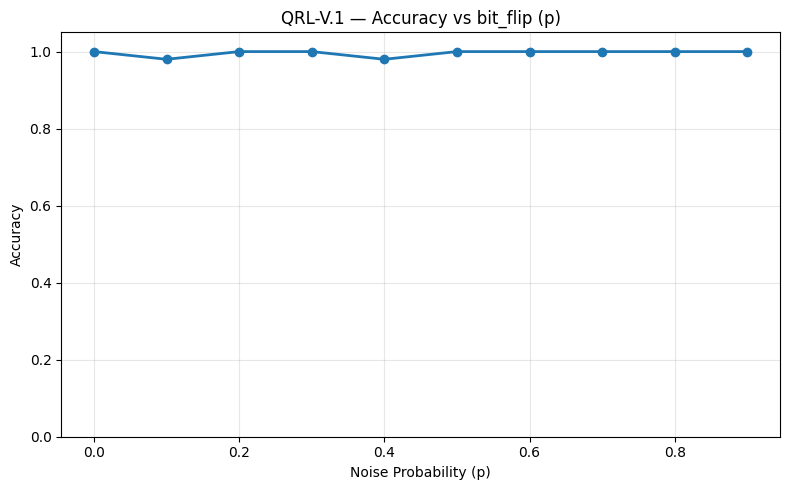

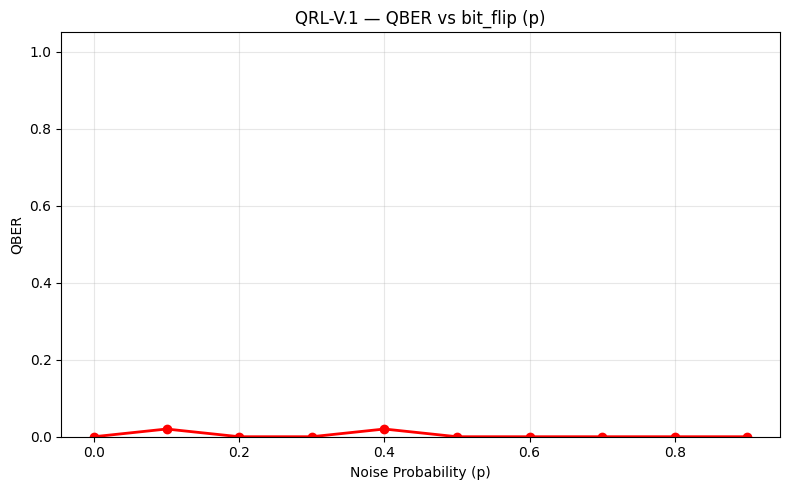


Running noise sweep for QNN-BB84 (depolarizing)...


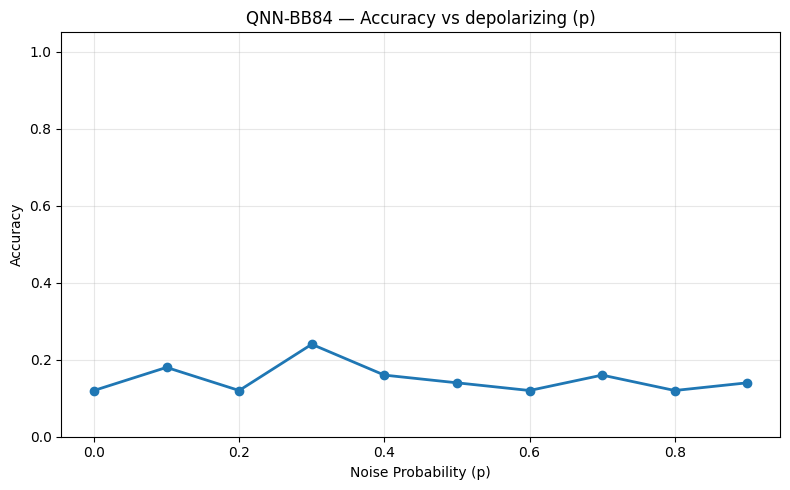

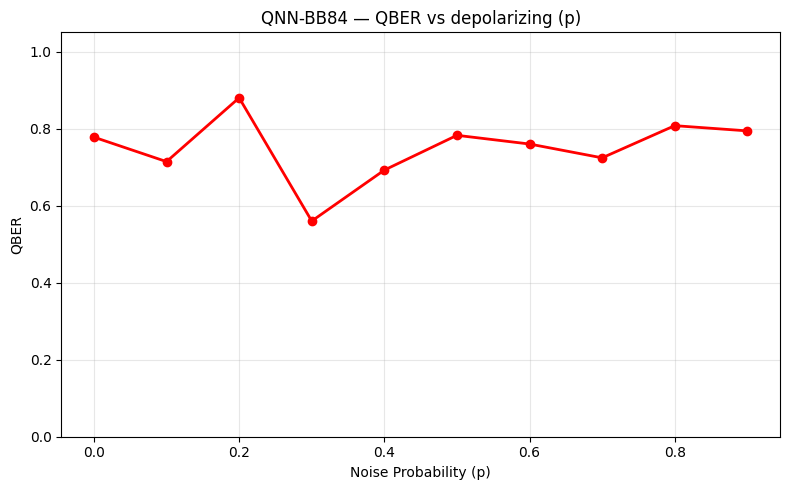

In [19]:
RUN_NOISE_DEMO = True

if RUN_NOISE_DEMO:
    # Noise probabilities to sweep
    PS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    # Example: Sweep bit-flip noise on QRL-V.1
    print("\nRunning noise sweep for QRL-V.1 (bit_flip)...")
    sweep_noise(evaluate_qrl_v1, PS, name="QRL-V.1",
                eval_kwargs={'N_bits': 50, 'iterations': 20},
                noise_type="bit_flip")

    # Example: Sweep depolarizing noise on QNN-BB84
    theta_demo = np.array([RNG.random() * 2 * math.pi for _ in range(3)])
    print("\nRunning noise sweep for QNN-BB84 (depolarizing)...")
    sweep_noise(evaluate_qnn_bb84, PS, name="QNN-BB84",
                eval_kwargs={'N_bits': 50, 'theta_params': theta_demo},
                noise_type="depolarizing")

## 17) Summary of Corrections

This corrected implementation addresses the following discrepancies from the original code:

| Issue | Original | Corrected |
|-------|----------|----------|
| Q-value tracking | Not implemented | Explicit `Q_values` dict maintained |
| Convergence check | Fixed iterations only | `abs(n3-n1) < epsilon` check added |
| Reward computation | Used score directly | Uses `max(P0, P1)` per Eq. (20) |
| Phase gate | Used RZ | Uses P gate to match paper |
| Final angle selection | Interval midpoint | `argmax Q(θ)` as per Algorithm 1 |
| B92 sifting | Minimal comments | Documented variant from canonical B92 |

### Paper Reference

Behera, B.K., Al-Kuwari, S., & Farouk, A. (2025). *QNN-QRL: Quantum Neural Network Integrated
with Quantum Reinforcement Learning for Quantum Key Distribution*. arXiv:2501.18188v2